In [36]:
# making noise

# but before that, get our imports done
import dLux as dl
import dLuxToliman as dlT
# gonna use normal numpy. jax numpy is weird. sike using jax
import numpy as np
from matplotlib import pyplot as plt
import dLux.utils as dlu
import jax
import jax.random as jr
import jax.numpy as jnp

# let's create the toliman pupil and obstructions, call it tolOptics

# might as well use 1024 pixels wavefront. nice and large number, prevent aliasing
wf_npixels = 1024

# smaller psf, only 10 sources. more than 18ish breaks on my macbook
psf_npixels = 128

# no need for oversampling
oversample = 1 # can change, put to 1 for normal toliman

# toliman pixel scale (arc seconds)
psf_pixel_scale = 0.375

# just for future use:
det_pixelsize = dlu.arcsec2rad(psf_pixel_scale/oversample)

tolOptics = dlT.TolimanOpticalSystem(wf_npixels, psf_npixels, oversample, psf_pixel_scale)

# now let's extract the pupil
tolPupil = tolOptics.pupil.opd

# make it a nice phase difference instead of OPD
tolPupilPhase = dlu.opd2phase(tolPupil, 585e-9) # it is pi phase difference for 585e-9 wavelength

# layer
tolPupilLayer = dl.layers.AberratedLayer(phase=tolPupilPhase)

# (normal toliman diameter)
diameter = 0.125

# initialsing coords for circular aperture
coords = dlu.pixel_coords(wf_npixels,diameter)

# x = np.arange(wf_npixels)
# y = np.arange(wf_npixels)
# X, Y = np.meshgrid(x,y, indexing = 'ij') # I believe the indexing part is neccessary? Anyway doesn't break anything

# creating the aperture (circular)
airyAperture = dlu.circle(coords,0.5 * diameter)

# making it a layer
airyApertureLayer = dl.layers.TransmissiveLayer(transmission=airyAperture, normalise=True)

# making the optical systems
tolPupilLayers = [
    (
        'aperture',
        airyApertureLayer
    ),
    (
        'pupil',
        tolPupilLayer
    )
]

airyApertureLayers = [
    (
        'aperture',
        airyApertureLayer
    )
]

tolPupilSystem = dl.AngularOpticalSystem(wf_npixels, diameter, tolPupilLayers, psf_npixels, psf_pixel_scale, oversample)

airyApertureSystem = dl.AngularOpticalSystem(wf_npixels, diameter, airyApertureLayers, psf_npixels, psf_pixel_scale, oversample)

# importing optax stuff
# Optimisation
import zodiax as zdx
import optax

from tqdm.notebook import tqdm


In [37]:
# modelling johson noise
# NOte: OVERSAMPLE SHOULD BE 1... unless.... we want 200% better pixel scale!!!
def bg_noise(dark_current, key): 
    noise_vals = (jnp.pi/2)**0.5*dark_current*jnp.abs(jr.normal(key, (psf_npixels*oversample,psf_npixels*oversample)))
    return noise_vals

# there is a 'addconstant' detector layer. but not sure how I can go from that to what I want.
# I think I just use it for modelling the mean value of detector noise.

In [38]:
r_rmse = jnp.zeros((6,5))
flux_rmse = jnp.zeros((6,5))
indices = jnp.arange(0,5)
currents = jnp.arange(2,14,2)
print(currents)
print(indices)
print(r_rmse)

[ 2  4  6  8 10 12]
[0 1 2 3 4]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [39]:
for c, current in enumerate(currents):
    for idx in indices:
        # gonna try 10 sources close(r) together... 50 takes way too long... prone to breaking on my silly macbook.
        n_sources = 10

        # good maximum for 512 by 512 grid
        max_pos = 20/oversample
        positions_arcsecs = jr.uniform(jr.PRNGKey(idx), (n_sources, 2), minval=-max_pos, maxval=max_pos)
        positions_rads = dlu.arcsec2rad(positions_arcsecs)

        # fluxes from half-normal distribution, standard deviation 50,000 photons
        fluxes = 50000*jnp.abs(jr.normal(jr.PRNGKey(idx), (n_sources,)))

        # only 1 wavelength
        wavelength = 585e-9 #mid(ish) point of toliman thing
        wavelengths = wavelength * jnp.linspace(1, 1, 1)

        sources = dl.PointSources(wavelengths,positions_rads,fluxes)

        # adding the constant to model dark current... not working too well!
        detector = dl.LayeredDetector([dl.layers.AddConstant(0)])

        tolTelescope = dl.Telescope(tolPupilSystem, sources, detector)
        airyTelescope = dl.Telescope(airyApertureSystem, sources, detector)

        init_dark_current = current
        # no poisson
        tolData = tolTelescope.model() + bg_noise(init_dark_current, jr.PRNGKey(idx))

        model_positions = 'source.position'
        model_fluxes = 'source.flux'

        # don't know about this one
        model_dark_current = 'detector.AddConstant.value'

        # params
        parameters = [model_positions, model_fluxes, model_dark_current]

        # just gonna do toliman for now
        # plus/mins 0.5 pixels in each dimension. gonna assume uniform distribution because nothing mentioned

        tolModel = tolTelescope.add(model_positions, jr.uniform(jr.PRNGKey(idx),(n_sources, 2),minval=-0.5*det_pixelsize,maxval=0.5*det_pixelsize))

        # fluxes +/- 10%
        tolModel = tolModel.multiply(model_fluxes, jr.uniform(jr.PRNGKey(idx), (n_sources,), minval=0.9, maxval=1.1))

        # dark current +/-20%
        tolModel = tolModel.add(model_dark_current, init_dark_current*jr.uniform(jr.PRNGKey(idx),1,minval=0.8,maxval=1.2))

        # this stuff really depends on how many sources you have
        pos_optimiser   = optax.adam(7e-9) # good value
        flux_optimiser  = optax.adam(200) # good value
        current_optimiser = optax.adam(0.02*0.2*init_dark_current)

        optimisers = [pos_optimiser, flux_optimiser, current_optimiser]

        optim, opt_state = zdx.get_optimiser(tolModel, parameters, optimisers)

        @zdx.filter_jit
        @zdx.filter_value_and_grad(parameters)
        def loss_fn(model, data):
            out = model.model()
            return jnp.sum((data-out)**2)

        losses, models_out = [], []
        min_iters = 100  # Ensure at least 100 iterations are completed before checking
        threshold = 0.01  # 1% change threshold

        losses, models_out = [], []
        with tqdm(range(400),desc='Gradient Descent') as t:
            for i in t: 
                loss, grads = loss_fn(tolModel, tolData)    
                updates, opt_state = optim.update(grads, opt_state)
                tolModel = zdx.apply_updates(tolModel, updates)
                losses.append(loss)
                models_out.append(tolModel)
                # Compute log loss and update progress bar
                log_loss = jnp.log10(loss)
                t.set_description("Log Loss: {:.3f}".format(log_loss)) 
                
                # Check for early stopping after at least 100 iterations
                if i >= min_iters:
                    recent_losses = jnp.log10(jnp.array(losses[-100:]))  # Last 100 losses
                    initial_loss = jnp.log10(recent_losses[0])
                    final_loss = jnp.log10(recent_losses[-1])
                    
                    if jnp.abs(final_loss - initial_loss) / initial_loss < threshold:
                        print(f"Early stopping at iteration {i} as log loss change is below {threshold * 100}%.")
                        break

        nepochs = len(models_out)
        psfs_out = models_out[-1].model()

        positions_found  = jnp.array([model.get(model_positions) for model in models_out])
        fluxes_found     = jnp.array([model.get(model_fluxes)    for model in models_out])
        current_found = jnp.array([model.get(model_dark_current) for model in models_out])

        flux_residuals = fluxes - fluxes_found
        current_residuals = init_dark_current - current_found

        #scaler = 1e3
        positions_residuals = positions_rads - positions_found
        r_residuals_rads = np.hypot(positions_residuals[:, :, 0], positions_residuals[:, :, 1])
        r_residuals = dlu.rad2arcsec(r_residuals_rads)
        flux_rmse = flux_rmse.at[c, idx].set(jnp.mean(flux_residuals[-1]**2)**0.5)
        r_rmse = r_rmse.at[c, idx].set(jnp.mean(r_residuals[-1]**2)**0.5)
        print(flux_rmse)
        print(r_rmse)


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at iteration 283 as log loss change is below 1.0%.
[[75.571335  0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.      ]]
[[0.00553193 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at iteration 219 as log loss change is below 1.0%.
[[75.571335 47.161503  0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.      ]]
[[0.00553193 0.00517957 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at iteration 250 as log loss change is below 1.0%.
[[75.571335 47.161503 51.26177   0.        0.      ]
 [ 0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.      ]]
[[0.00553193 0.00517957 0.00194596 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at iteration 277 as log loss change is below 1.0%.
[[75.571335 47.161503 51.26177  53.96424   0.      ]
 [ 0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.      ]]
[[0.00553193 0.00517957 0.00194596 0.00201075 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

[[75.571335 47.161503 51.26177  53.96424        nan]
 [ 0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.      ]]
[[0.00553193 0.00517957 0.00194596 0.00201075        nan]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at iteration 244 as log loss change is below 1.0%.
[[ 75.571335  47.161503  51.26177   53.96424         nan]
 [149.89934    0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]]
[[0.00553193 0.00517957 0.00194596 0.00201075        nan]
 [0.01150832 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at iteration 189 as log loss change is below 1.0%.
[[ 75.571335  47.161503  51.26177   53.96424         nan]
 [149.89934   92.075485   0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]]
[[0.00553193 0.00517957 0.00194596 0.00201075        nan]
 [0.01150832 0.01082105 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at iteration 213 as log loss change is below 1.0%.
[[ 75.571335  47.161503  51.26177   53.96424         nan]
 [149.89934   92.075485 103.50724    0.         0.      ]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]]
[[0.00553193 0.00517957 0.00194596 0.00201075        nan]
 [0.01150832 0.01082105 0.00431143 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at iteration 240 as log loss change is below 1.0%.
[[ 75.571335  47.161503  51.26177   53.96424         nan]
 [149.89934   92.075485 103.50724  108.734726   0.      ]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]]
[[0.00553193 0.00517957 0.00194596 0.00201075        nan]
 [0.01150832 0.01082105 0.00431143 0.00411331 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

[[ 75.571335  47.161503  51.26177   53.96424         nan]
 [149.89934   92.075485 103.50724  108.734726        nan]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]]
[[0.00553193 0.00517957 0.00194596 0.00201075        nan]
 [0.01150832 0.01082105 0.00431143 0.00411331        nan]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at iteration 219 as log loss change is below 1.0%.
[[ 75.571335  47.161503  51.26177   53.96424         nan]
 [149.89934   92.075485 103.50724  108.734726        nan]
 [223.03758    0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]]
[[0.00553193 0.00517957 0.00194596 0.00201075        nan]
 [0.01150832 0.01082105 0.00431143 0.00411331        nan]
 [0.01800553 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at iteration 170 as log loss change is below 1.0%.
[[ 75.571335  47.161503  51.26177   53.96424         nan]
 [149.89934   92.075485 103.50724  108.734726        nan]
 [223.03758  135.21478    0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]]
[[0.00553193 0.00517957 0.00194596 0.00201075        nan]
 [0.01150832 0.01082105 0.00431143 0.00411331        nan]
 [0.01800553 0.01673703 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at iteration 189 as log loss change is below 1.0%.
[[ 75.571335  47.161503  51.26177   53.96424         nan]
 [149.89934   92.075485 103.50724  108.734726        nan]
 [223.03758  135.21478  156.6085     0.         0.      ]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]]
[[0.00553193 0.00517957 0.00194596 0.00201075        nan]
 [0.01150832 0.01082105 0.00431143 0.00411331        nan]
 [0.01800553 0.01673703 0.00710436 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at iteration 215 as log loss change is below 1.0%.
[[ 75.571335  47.161503  51.26177   53.96424         nan]
 [149.89934   92.075485 103.50724  108.734726        nan]
 [223.03758  135.21478  156.6085   162.98984    0.      ]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]]
[[0.00553193 0.00517957 0.00194596 0.00201075        nan]
 [0.01150832 0.01082105 0.00431143 0.00411331        nan]
 [0.01800553 0.01673703 0.00710436 0.0064271  0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

[[ 75.571335  47.161503  51.26177   53.96424         nan]
 [149.89934   92.075485 103.50724  108.734726        nan]
 [223.03758  135.21478  156.6085   162.98984         nan]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]]
[[0.00553193 0.00517957 0.00194596 0.00201075        nan]
 [0.01150832 0.01082105 0.00431143 0.00411331        nan]
 [0.01800553 0.01673703 0.00710436 0.0064271         nan]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at iteration 198 as log loss change is below 1.0%.
[[ 75.571335  47.161503  51.26177   53.96424         nan]
 [149.89934   92.075485 103.50724  108.734726        nan]
 [223.03758  135.21478  156.6085   162.98984         nan]
 [297.1026     0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]]
[[0.00553193 0.00517957 0.00194596 0.00201075        nan]
 [0.01150832 0.01082105 0.00431143 0.00411331        nan]
 [0.01800553 0.01673703 0.00710436 0.0064271         nan]
 [0.0251311  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at iteration 156 as log loss change is below 1.0%.
[[ 75.571335  47.161503  51.26177   53.96424         nan]
 [149.89934   92.075485 103.50724  108.734726        nan]
 [223.03758  135.21478  156.6085   162.98984         nan]
 [297.1026   177.1145     0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]]
[[0.00553193 0.00517957 0.00194596 0.00201075        nan]
 [0.01150832 0.01082105 0.00431143 0.00411331        nan]
 [0.01800553 0.01673703 0.00710436 0.0064271         nan]
 [0.0251311  0.02268828 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at iteration 170 as log loss change is below 1.0%.
[[ 75.571335  47.161503  51.26177   53.96424         nan]
 [149.89934   92.075485 103.50724  108.734726        nan]
 [223.03758  135.21478  156.6085   162.98984         nan]
 [297.1026   177.1145   210.60889    0.         0.      ]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]]
[[0.00553193 0.00517957 0.00194596 0.00201075        nan]
 [0.01150832 0.01082105 0.00431143 0.00411331        nan]
 [0.01800553 0.01673703 0.00710436 0.0064271         nan]
 [0.0251311  0.02268828 0.01037287 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at iteration 197 as log loss change is below 1.0%.
[[ 75.571335  47.161503  51.26177   53.96424         nan]
 [149.89934   92.075485 103.50724  108.734726        nan]
 [223.03758  135.21478  156.6085   162.98984         nan]
 [297.1026   177.1145   210.60889  215.8731     0.      ]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]]
[[0.00553193 0.00517957 0.00194596 0.00201075        nan]
 [0.01150832 0.01082105 0.00431143 0.00411331        nan]
 [0.01800553 0.01673703 0.00710436 0.0064271         nan]
 [0.0251311  0.02268828 0.01037287 0.00894017 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

[[ 75.571335  47.161503  51.26177   53.96424         nan]
 [149.89934   92.075485 103.50724  108.734726        nan]
 [223.03758  135.21478  156.6085   162.98984         nan]
 [297.1026   177.1145   210.60889  215.8731          nan]
 [  0.         0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]]
[[0.00553193 0.00517957 0.00194596 0.00201075        nan]
 [0.01150832 0.01082105 0.00431143 0.00411331        nan]
 [0.01800553 0.01673703 0.00710436 0.0064271         nan]
 [0.0251311  0.02268828 0.01037287 0.00894017        nan]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at iteration 180 as log loss change is below 1.0%.
[[ 75.571335  47.161503  51.26177   53.96424         nan]
 [149.89934   92.075485 103.50724  108.734726        nan]
 [223.03758  135.21478  156.6085   162.98984         nan]
 [297.1026   177.1145   210.60889  215.8731          nan]
 [377.66074    0.         0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]]
[[0.00553193 0.00517957 0.00194596 0.00201075        nan]
 [0.01150832 0.01082105 0.00431143 0.00411331        nan]
 [0.01800553 0.01673703 0.00710436 0.0064271         nan]
 [0.0251311  0.02268828 0.01037287 0.00894017        nan]
 [0.03297077 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at iteration 144 as log loss change is below 1.0%.
[[ 75.571335  47.161503  51.26177   53.96424         nan]
 [149.89934   92.075485 103.50724  108.734726        nan]
 [223.03758  135.21478  156.6085   162.98984         nan]
 [297.1026   177.1145   210.60889  215.8731          nan]
 [377.66074  216.68155    0.         0.         0.      ]
 [  0.         0.         0.         0.         0.      ]]
[[0.00553193 0.00517957 0.00194596 0.00201075        nan]
 [0.01150832 0.01082105 0.00431143 0.00411331        nan]
 [0.01800553 0.01673703 0.00710436 0.0064271         nan]
 [0.0251311  0.02268828 0.01037287 0.00894017        nan]
 [0.03297077 0.02896033 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at iteration 155 as log loss change is below 1.0%.
[[ 75.571335  47.161503  51.26177   53.96424         nan]
 [149.89934   92.075485 103.50724  108.734726        nan]
 [223.03758  135.21478  156.6085   162.98984         nan]
 [297.1026   177.1145   210.60889  215.8731          nan]
 [377.66074  216.68155  264.61115    0.         0.      ]
 [  0.         0.         0.         0.         0.      ]]
[[0.00553193 0.00517957 0.00194596 0.00201075        nan]
 [0.01150832 0.01082105 0.00431143 0.00411331        nan]
 [0.01800553 0.01673703 0.00710436 0.0064271         nan]
 [0.0251311  0.02268828 0.01037287 0.00894017        nan]
 [0.03297077 0.02896033 0.01392952 0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at iteration 181 as log loss change is below 1.0%.
[[ 75.571335  47.161503  51.26177   53.96424         nan]
 [149.89934   92.075485 103.50724  108.734726        nan]
 [223.03758  135.21478  156.6085   162.98984         nan]
 [297.1026   177.1145   210.60889  215.8731          nan]
 [377.66074  216.68155  264.61115  266.73914    0.      ]
 [  0.         0.         0.         0.         0.      ]]
[[0.00553193 0.00517957 0.00194596 0.00201075        nan]
 [0.01150832 0.01082105 0.00431143 0.00411331        nan]
 [0.01800553 0.01673703 0.00710436 0.0064271         nan]
 [0.0251311  0.02268828 0.01037287 0.00894017        nan]
 [0.03297077 0.02896033 0.01392952 0.01175985 0.        ]
 [0.         0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

[[ 75.571335  47.161503  51.26177   53.96424         nan]
 [149.89934   92.075485 103.50724  108.734726        nan]
 [223.03758  135.21478  156.6085   162.98984         nan]
 [297.1026   177.1145   210.60889  215.8731          nan]
 [377.66074  216.68155  264.61115  266.73914         nan]
 [  0.         0.         0.         0.         0.      ]]
[[0.00553193 0.00517957 0.00194596 0.00201075        nan]
 [0.01150832 0.01082105 0.00431143 0.00411331        nan]
 [0.01800553 0.01673703 0.00710436 0.0064271         nan]
 [0.0251311  0.02268828 0.01037287 0.00894017        nan]
 [0.03297077 0.02896033 0.01392952 0.01175985        nan]
 [0.         0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at iteration 165 as log loss change is below 1.0%.
[[ 75.571335  47.161503  51.26177   53.96424         nan]
 [149.89934   92.075485 103.50724  108.734726        nan]
 [223.03758  135.21478  156.6085   162.98984         nan]
 [297.1026   177.1145   210.60889  215.8731          nan]
 [377.66074  216.68155  264.61115  266.73914         nan]
 [467.3811     0.         0.         0.         0.      ]]
[[0.00553193 0.00517957 0.00194596 0.00201075        nan]
 [0.01150832 0.01082105 0.00431143 0.00411331        nan]
 [0.01800553 0.01673703 0.00710436 0.0064271         nan]
 [0.0251311  0.02268828 0.01037287 0.00894017        nan]
 [0.03297077 0.02896033 0.01392952 0.01175985        nan]
 [0.0415207  0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at iteration 134 as log loss change is below 1.0%.
[[ 75.571335  47.161503  51.26177   53.96424         nan]
 [149.89934   92.075485 103.50724  108.734726        nan]
 [223.03758  135.21478  156.6085   162.98984         nan]
 [297.1026   177.1145   210.60889  215.8731          nan]
 [377.66074  216.68155  264.61115  266.73914         nan]
 [467.3811   254.77928    0.         0.         0.      ]]
[[0.00553193 0.00517957 0.00194596 0.00201075        nan]
 [0.01150832 0.01082105 0.00431143 0.00411331        nan]
 [0.01800553 0.01673703 0.00710436 0.0064271         nan]
 [0.0251311  0.02268828 0.01037287 0.00894017        nan]
 [0.03297077 0.02896033 0.01392952 0.01175985        nan]
 [0.0415207  0.03524419 0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at iteration 141 as log loss change is below 1.0%.
[[ 75.571335  47.161503  51.26177   53.96424         nan]
 [149.89934   92.075485 103.50724  108.734726        nan]
 [223.03758  135.21478  156.6085   162.98984         nan]
 [297.1026   177.1145   210.60889  215.8731          nan]
 [377.66074  216.68155  264.61115  266.73914         nan]
 [467.3811   254.77928  321.0199     0.         0.      ]]
[[0.00553193 0.00517957 0.00194596 0.00201075        nan]
 [0.01150832 0.01082105 0.00431143 0.00411331        nan]
 [0.01800553 0.01673703 0.00710436 0.0064271         nan]
 [0.0251311  0.02268828 0.01037287 0.00894017        nan]
 [0.03297077 0.02896033 0.01392952 0.01175985        nan]
 [0.0415207  0.03524419 0.01811046 0.         0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at iteration 167 as log loss change is below 1.0%.
[[ 75.571335  47.161503  51.26177   53.96424         nan]
 [149.89934   92.075485 103.50724  108.734726        nan]
 [223.03758  135.21478  156.6085   162.98984         nan]
 [297.1026   177.1145   210.60889  215.8731          nan]
 [377.66074  216.68155  264.61115  266.73914         nan]
 [467.3811   254.77928  321.0199   315.51483    0.      ]]
[[0.00553193 0.00517957 0.00194596 0.00201075        nan]
 [0.01150832 0.01082105 0.00431143 0.00411331        nan]
 [0.01800553 0.01673703 0.00710436 0.0064271         nan]
 [0.0251311  0.02268828 0.01037287 0.00894017        nan]
 [0.03297077 0.02896033 0.01392952 0.01175985        nan]
 [0.0415207  0.03524419 0.01811046 0.01481319 0.        ]]


Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

[[ 75.571335  47.161503  51.26177   53.96424         nan]
 [149.89934   92.075485 103.50724  108.734726        nan]
 [223.03758  135.21478  156.6085   162.98984         nan]
 [297.1026   177.1145   210.60889  215.8731          nan]
 [377.66074  216.68155  264.61115  266.73914         nan]
 [467.3811   254.77928  321.0199   315.51483         nan]]
[[0.00553193 0.00517957 0.00194596 0.00201075        nan]
 [0.01150832 0.01082105 0.00431143 0.00411331        nan]
 [0.01800553 0.01673703 0.00710436 0.0064271         nan]
 [0.0251311  0.02268828 0.01037287 0.00894017        nan]
 [0.03297077 0.02896033 0.01392952 0.01175985        nan]
 [0.0415207  0.03524419 0.01811046 0.01481319        nan]]


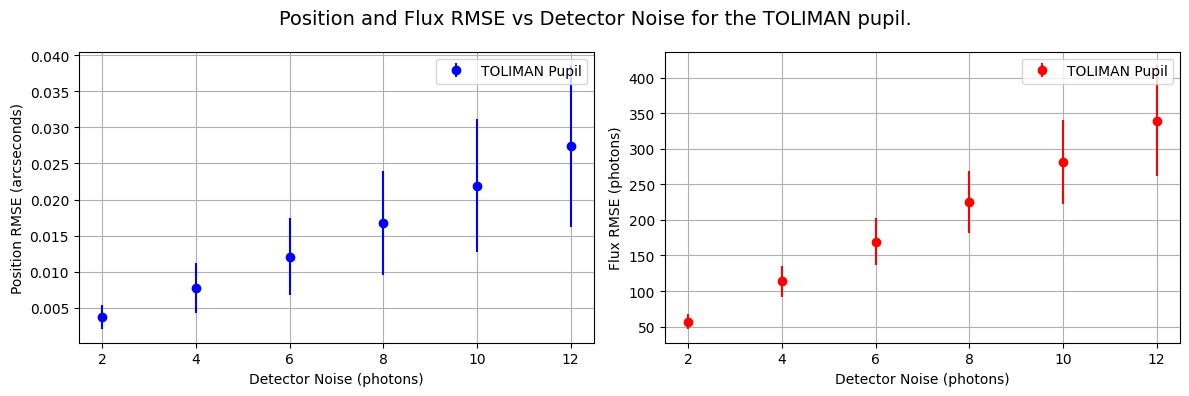

In [56]:
flux_means = jnp.nanmean(flux_rmse[:,:4],axis=1)
r_means = jnp.nanmean(r_rmse[:,:4],axis=1)
flux_sds = jnp.nanstd(flux_rmse[:,:4],axis=1)
r_sds = jnp.nanstd(r_rmse[:,:4],axis=1)

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Position RMSE subplot
axes[0].errorbar(currents, r_means, yerr=r_sds, fmt='o', color='blue', label="TOLIMAN Pupil")
axes[0].set_xlabel('Detector Noise (photons)')
axes[0].set_ylabel('Position RMSE (arcseconds)')
axes[0].legend()
axes[0].grid(True)

# Flux RMSE subplot
axes[1].errorbar(currents, flux_means, yerr=flux_sds, fmt='o', color='red', label="TOLIMAN Pupil")
axes[1].set_xlabel('Detector Noise (photons)')
axes[1].set_ylabel('Flux RMSE (photons)')
axes[1].legend()
axes[1].grid(True)

# Add a big title
fig.suptitle('Position and Flux RMSE vs Detector Noise for the TOLIMAN pupil.', fontsize=14)
plt.tight_layout()


In [ ]:
# In theory, shouldn't be too hard to do airy disk, diffuser. Just takes a long time to run. Also only do up to 4 for each noise level.